BUSINESS PROBLEM

In buisness,targeted marketing has been one of the keys to effectiveness. The idea of segmentation helps companies to understand customers' needs and provide them with relevant product information.So using Unsupervised models to recommend Products to customers by performing customer segmentation.

In [69]:
from google.colab import drive
import numpy as np
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## IMPORTS

In [70]:
# Importing all the Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans
import datetime as dt

### Reading the dataset 

In [71]:
 df = pd.read_excel('/content/drive/My Drive/Project/Online_retail.xlsx')

In [72]:
# Number of rows and columns in data set

print("Number of rows in dataset is: ", df.shape[0])
print("Number of columns in dataset is: ", df.shape[1])

Number of rows in dataset is:  541909
Number of columns in dataset is:  8


## PHASE 1: Data Cleaning/ Preprocessing


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


From the above information we can conclude that column Description and CustomerID contains some missing values. For purposes of customer segmentation missing ids will be dropped further.


In [74]:
print("Number of unique customers for the company:", len(df['CustomerID'].unique().tolist()))

Number of unique customers for the company: 4373


Performing descriptive statistics

In [75]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


### Analysing the reason of negative values in these variables.

In [76]:
quantity_negative_values = df[df['Quantity']<0]
quantity_negative_values.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


 From the above data, it seems Quatity with negative values are cancelled transaction as InvoiceNo starts with prefix 'C'.
 
 Lets analyse UnitPrice,

In [77]:
unitprice_negative_values = df[df['UnitPrice']<0]
unitprice_negative_values.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


In [78]:
unitprice_zero = df[df['UnitPrice']==0]
unitprice_zero.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom


In [79]:
len(unitprice_zero)

2515

 Transaction with negative unit price are debt adjust and with unitprice 0.0 there is no proper description nor customer Id associated with it. Hence it can be dropped.

#### percentage of transactions to be dropped

In [80]:
print("Percentage of cancelled transactions:" , round(len(quantity_negative_values)/len(df)*100, 2),"%")
print("Precentage of transactions with zero or negative price" ,round(len(df[df['UnitPrice']<=0])/len(df)*100, 2),"%")

Percentage of cancelled transactions: 1.96 %
Precentage of transactions with zero or negative price 0.46 %


#### Intermediate dataframe

In [81]:
df_inter = df[(df['UnitPrice'] > 0) & (df['Quantity']>0)]

In [82]:
df_inter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 530104 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    530104 non-null  object        
 1   StockCode    530104 non-null  object        
 2   Description  530104 non-null  object        
 3   Quantity     530104 non-null  int64         
 4   InvoiceDate  530104 non-null  datetime64[ns]
 5   UnitPrice    530104 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      530104 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 36.4+ MB


Null values in description has gone after deleting error transactions

### Cleaning Description

In [83]:
#removing punctuations

df_inter['Description'] = df_inter['Description'].str.lower()
df_inter['Description'] = df_inter['Description'].replace(to_replace=r'[^\w\s]', value='', regex=True) 

print("Number of unique descriptions:", len(df_inter['Description'].unique().tolist()))

Number of unique descriptions: 4016


### Cleaning Stock code

In [84]:
df_inter.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,white hanging heart tlight holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,red woolly hottie white heart,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [85]:
print(len(df_inter))

530104


Stock code usually will be numeric, hence removing letters from it.

In [86]:
df_inter = df_inter.loc[df_inter['StockCode'].astype(str).str[0:4].str.isdigit()]

print("Number of unique descriptions:",len(df_inter['StockCode'].unique().tolist()))

Number of unique descriptions: 3900


In [87]:
df_inter.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,white hanging heart tlight holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,red woolly hottie white heart,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Dropping customerId with null values

In [88]:
df_inter = df_inter.dropna()
df_inter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 396337 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    396337 non-null  object        
 1   StockCode    396337 non-null  object        
 2   Description  396337 non-null  object        
 3   Quantity     396337 non-null  int64         
 4   InvoiceDate  396337 non-null  datetime64[ns]
 5   UnitPrice    396337 non-null  float64       
 6   CustomerID   396337 non-null  float64       
 7   Country      396337 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.2+ MB


In [89]:
df_inter.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,white hanging heart tlight holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,red woolly hottie white heart,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Adding new columns for analysis

In [90]:
# adding amount spend on invoice
df_inter['amount'] =df_inter['Quantity']*df_inter['UnitPrice']

In [91]:
# adding date columns as year, month, month_year, day of week, hour

df_inter['month'] = df_inter['InvoiceDate'].dt.month
df_inter['year'] = df_inter['InvoiceDate'].dt.year
df_inter['WeekDay'] = df_inter['InvoiceDate'].dt.day_name()
df_inter['month_year'] = pd.to_datetime(df_inter[['year', 'month']].assign(Day=1))
df_inter['hour'] = df_inter['InvoiceDate'].dt.hour
df_inter.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount,month,year,WeekDay,month_year,hour
0,536365,85123A,white hanging heart tlight holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,12,2010,Wednesday,2010-12-01,8
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12,2010,Wednesday,2010-12-01,8
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,12,2010,Wednesday,2010-12-01,8
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12,2010,Wednesday,2010-12-01,8
4,536365,84029E,red woolly hottie white heart,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,12,2010,Wednesday,2010-12-01,8


In [92]:
df_final = df_inter

# PHASE 2: EDA

###  1. Total Purchase over period of time

#### 1a. Orders per month

<Axes: xlabel='month', ylabel='InvoiceNo'>

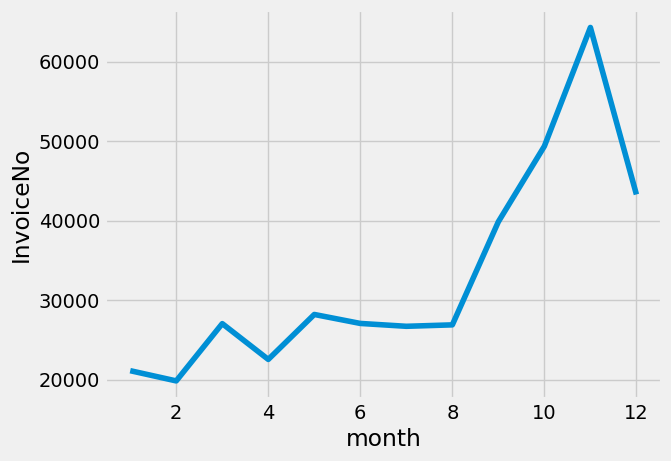

In [93]:
# Code adapted from Dekseniya's Online Retail Dataset solution (EDA + RFM) 
# Source:  "Online Retail Dataset solution (EDA + RFM)", Dekseniya, URL: https://github.com/dekseniya/Online-Retail-Dataset/blob/master/Online%20Retail%20Dataset%20solution%20(EDA%20%2BRFM).ipynb

monthly_orders = df_final.groupby("month")['InvoiceNo'].count().reset_index()
sns.lineplot(x='month', y='InvoiceNo', data=monthly_orders)

#### 1b. orders per weekday

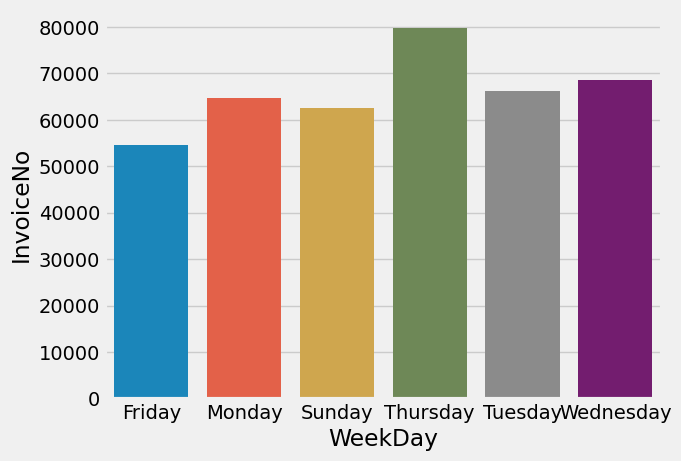

In [94]:
# Code adapted from Dekseniya's Online Retail Dataset solution (EDA + RFM) 
# Source:  "Online Retail Dataset solution (EDA + RFM)", Dekseniya, URL: https://github.com/dekseniya/Online-Retail-Dataset/blob/master/Online%20Retail%20Dataset%20solution%20(EDA%20%2BRFM).ipynb

perday_orders = df_final.groupby("WeekDay")['InvoiceNo'].count().reset_index()
ax = sns.barplot(x="WeekDay", y="InvoiceNo", data = perday_orders)

#### 1c. orders per hour

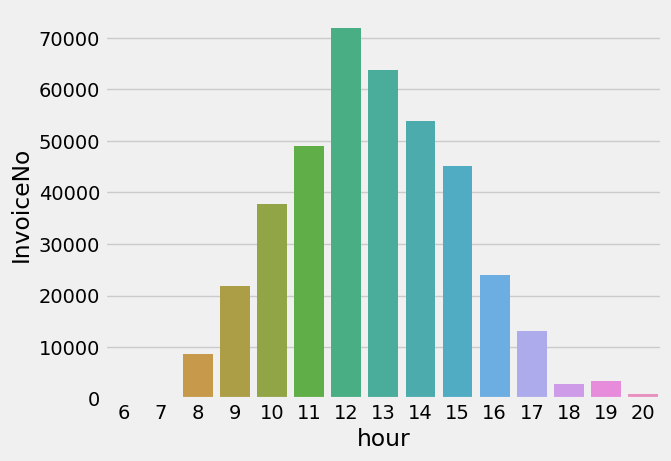

In [95]:
# Code adapted from Dekseniya's Online Retail Dataset solution (EDA + RFM) 
# Source:  "Online Retail Dataset solution (EDA + RFM)", Dekseniya, URL: https://github.com/dekseniya/Online-Retail-Dataset/blob/master/Online%20Retail%20Dataset%20solution%20(EDA%20%2BRFM).ipynb

perhour_orders = df_final.groupby('hour')['InvoiceNo'].count().reset_index()  
ax = sns.barplot(x="hour", y="InvoiceNo", data = perhour_orders)

#### 1d. Total revenue per month

<Axes: xlabel='month', ylabel='amount'>

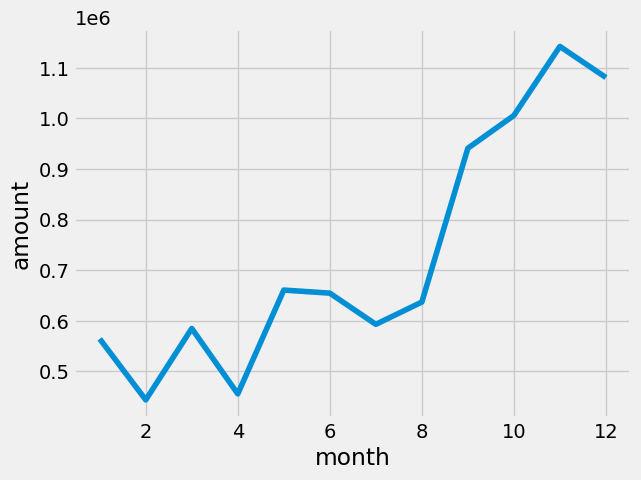

In [96]:
# Code adapted from Dekseniya's Online Retail Dataset solution (EDA + RFM) 
# Source:  "Online Retail Dataset solution (EDA + RFM)", Dekseniya, URL: https://github.com/dekseniya/Online-Retail-Dataset/blob/master/Online%20Retail%20Dataset%20solution%20(EDA%20%2BRFM).ipynb

monthly_revenue = df_final.groupby("month")['amount'].sum().reset_index()
sns.lineplot(x='month', y='amount', data=monthly_revenue)

###  2.Top Customers with High Purchase

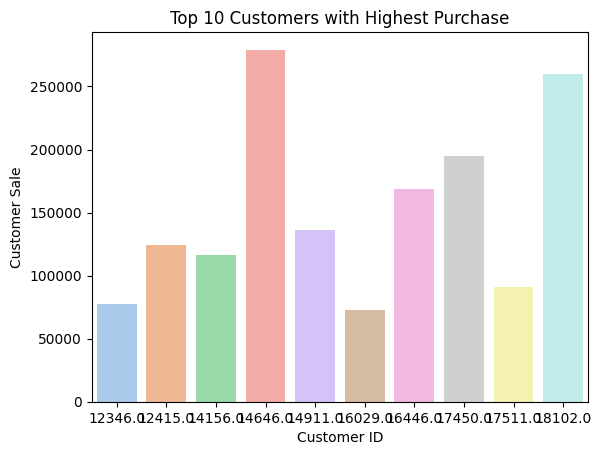

In [35]:
# Create a custom color palette for the plot
colors = sns.color_palette('pastel')[0:10]

# Create a new DataFrame with the top 10 customers and their total purchase amounts
Top10_Customer = df_final.groupby('CustomerID')['amount'].sum().sort_values(ascending=False).head(10).reset_index()

# Plot the data using Seaborn's barplot function
ax = sns.barplot(x='CustomerID', y='amount', data=Top10_Customer, palette=colors)

# Add labels and a title to the plot
ax.set_ylabel('Customer Sale')
ax.set_xlabel('Customer ID')
ax.set_title('Top 10 Customers with Highest Purchase')

# Show the plot
plt.show();





### 3. Top Products With High Sales

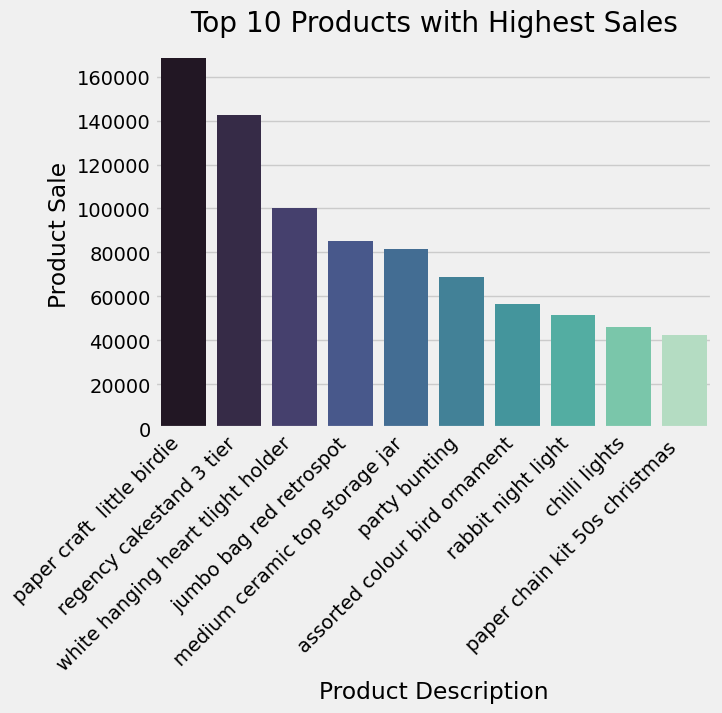

In [97]:
# Create a new DataFrame with the top 10 products and their total sale amounts
Top10Products = df_final.groupby('Description')['amount'].sum().sort_values(ascending=False).head(10).reset_index()

# Set the color palette for the plot
colors = sns.color_palette('mako', n_colors=len(Top10Products))

# Plot the data using Seaborn's barplot function
ax = sns.barplot(x='Description', y='amount', data=Top10Products, palette=colors)

# Add labels and a title to the plot
ax.set_ylabel('Product Sale')
ax.set_xlabel('Product Description')
ax.set_title('Top 10 Products with Highest Sales')

# Rotate the x-axis labels to prevent overlap
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Show the plot
plt.show()

### 4. Countries With High Sales

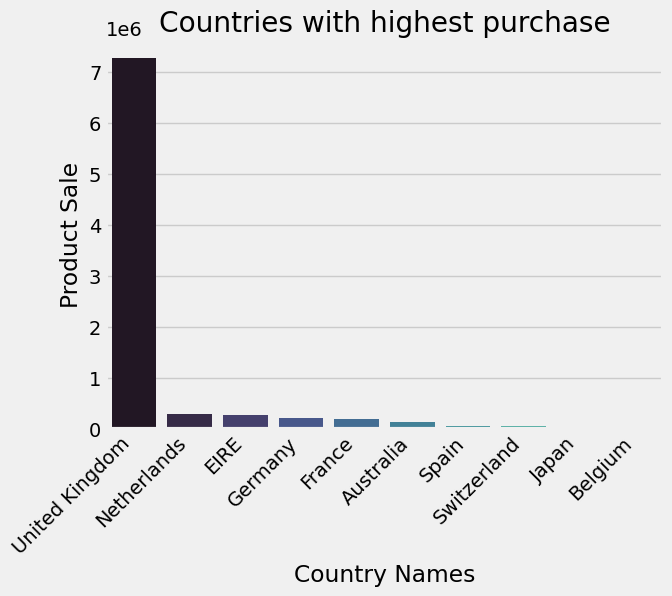

In [98]:
# Create a new DataFrame with the top 10 countries and their total sale amounts
Top10Products = df_final.groupby('Country')['amount'].sum().sort_values(ascending=False).head(10).reset_index()

# Set the color palette for the plot
colors = sns.color_palette('mako', n_colors=len(Top10Products))

# Plot the data using Seaborn's barplot function
ax = sns.barplot(x='Country', y='amount', data=Top10Products, palette=colors)

# Add labels and a title to the plot
ax.set_ylabel('Product Sale')
ax.set_xlabel('Country Names')
ax.set_title('Countries with highest purchase')

# Rotate the x-axis labels to prevent overlap
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Show the plot
plt.show()

### 4. Countries With High Orders

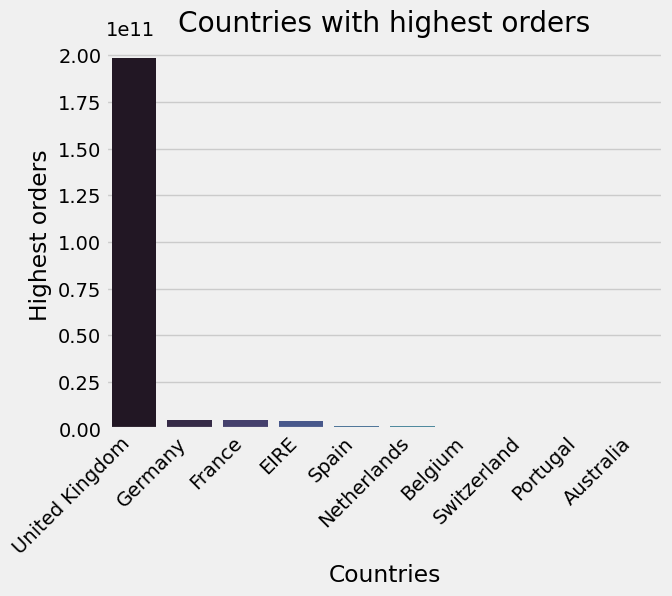

In [99]:
# Create a new DataFrame with the top 10 countries and their total sale amounts
Top10Products = df_final.groupby('Country')['InvoiceNo'].sum().sort_values(ascending=False).head(10).reset_index()

# Set the color palette for the plot
colors = sns.color_palette('mako', n_colors=len(Top10Products))

# Plot the data using Seaborn's barplot function
ax = sns.barplot(x='Country', y='InvoiceNo', data=Top10Products, palette=colors)

# Add labels and a title to the plot
ax.set_ylabel('Highest orders')
ax.set_xlabel('Countries')
ax.set_title('Countries with highest orders')

# Rotate the x-axis labels to prevent overlap
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Show the plot
plt.show()


# PHASE 3: FEATURE ENGINEERING
  1. Recency - refers to the time since the customer's last purchase. 
  2. Frequency - refers to the number of purchases made by the customer.
  3. Monetary refers to the total amount spent by the customer. 


#### step 1: calaculating all 3 new columns, recency, frequency, Monetary


In [100]:
# convert the transaction date column to a datetime data type
df_final['InvoiceDate'] = pd.to_datetime(df_final['InvoiceDate'])

In [101]:
# calculate recency, frequency, and monetary value for each customer
snapshot_date = dt.datetime(2012, 1, 1)
rfm = df_final.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'amount': 'sum'
}).reset_index()

In [102]:
# rename the columns to recency, frequency, and monetary
rfm.rename(columns={
    'InvoiceDate': 'recency',
    'InvoiceNo': 'frequency',
    'amount': 'monetary'
}, inplace=True)

Removing outlier's from RFM values

In [103]:
 # Removing (statistical) outliers for Monetary
Q1 = rfm.monetary.quantile(0.05)
Q3 = rfm.monetary.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.monetary >= Q1 - 1.5*IQR) & (rfm.monetary <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Recency
Q1 = rfm.recency.quantile(0.05)
Q3 = rfm.recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.recency >= Q1 - 1.5*IQR) & (rfm.recency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = rfm.frequency.quantile(0.05)
Q3 = rfm.frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.frequency >= Q1 - 1.5*IQR) & (rfm.frequency <= Q3 + 1.5*IQR)]

plotting the distribution of RFM values

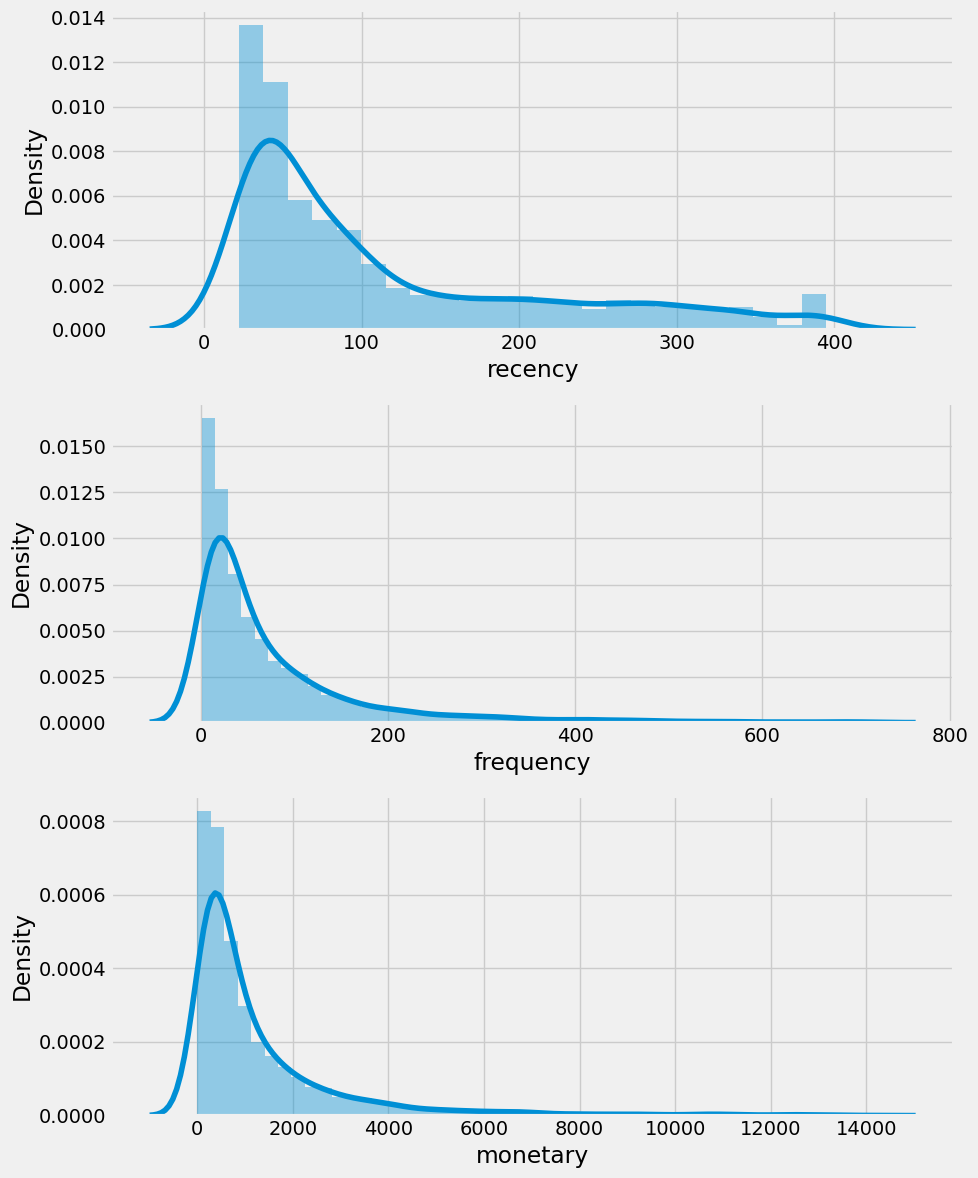

In [104]:

f,ax = plt.subplots(figsize=(10, 12))
plt.subplot(3, 1, 1); sns.distplot(rfm.recency, label = 'recency')
plt.subplot(3, 1, 2); sns.distplot(rfm.frequency, label = 'frequency')
plt.subplot(3, 1, 3); sns.distplot(rfm.monetary, label = 'monetary')
plt.style.use('fivethirtyeight')
plt.tight_layout()
plt.show();

#### step 2: Using 'quartiles' to cut the distribution of the RFM values.


Recency score: Calculating the number of days since the customer's last purchase. Assigning a score from 1 to 5 based on the recency, with 5 being the most recent and 1 being the least recent. 

    For example, if a customer made a purchase 10 days ago, they receive a recency score of 5, while a customer who made a purchase 200 days ago might receive a recency score of 1.



In [105]:
# add the recency score column to the RFM dataframe

recency_range = rfm['recency'].describe()

bins = [0, recency_range['min'], recency_range['25%'], recency_range['50%'], recency_range['75%'], recency_range['max']]
labels = [5,4,3,2,1]
rfm['recency_score'] = pd.cut(rfm['recency'], bins=bins, labels=labels)

Frequency score: Calculating the total number of purchases made by the customer. Assigning a score from 1 to 5 based on the frequency, with 5 being the most frequent and 1 being the least frequent. 

    For example, if a customer made 10 purchases, they might receive a frequency score of 5, while a customer who made only 1 purchase receive a frequency score of 1.



In [106]:
# Using quartiles to cut the distribution of the 'frequency' values.

frequency_range = rfm['frequency'].describe()

bins = [0, frequency_range['min'], frequency_range['25%'], frequency_range['50%'], frequency_range['75%'], frequency_range['max']]
labels = [1, 2, 3, 4, 5]


rfm['frequency_score'] = pd.cut(rfm['frequency'], bins=bins, labels=labels)


 Monetary score: Calculating the total amount of money spent by the customer.  Assigning a score from 1 to 5 based on the monetary value, with 5 being the highest spending and 1 being the lowest spending. 

    For example, if a customer spent $1,000, they might receive a monetary score of 5, while a customer who spent only $10, receive a monetary score of 1.

In [107]:
# add the monetary score column to the RFM dataframe

monetary_range = rfm['monetary'].describe()

bins = [0, monetary_range['min'], monetary_range['25%'], monetary_range['50%'], monetary_range['75%'], monetary_range['max']]
labels = [1, 2, 3, 4, 5]

rfm['monetary_score'] = pd.cut(rfm['monetary'], bins=bins, labels=labels)


Caculating single RFM score by concatenating above three scores.

In [108]:
# Calculating RFM Scores
# We are creating the RFM score.
rfm["rfm_score"] = (rfm['recency_score'].astype(str) +
                    rfm['frequency_score'].astype(str) +
                    rfm['monetary_score'].astype(str))

rfm['rfm_score'] = rfm['rfm_score'].astype(int)
              

In [51]:
rfm_final = rfm[['CustomerID','recency_score','frequency_score','monetary_score','rfm_score']]


# PHASE 4: UNSUPERVISED MACHINE LEARNING




### Model Training

In [109]:
columns_for_clustering = ['recency_score', 'frequency_score', 'monetary_score', 'rfm_score']
X = rfm_final[columns_for_clustering]

In [110]:
# Determine the optimal number of clusters using an elbow plot
# Optional step to find the optimal number of clusters
from sklearn.metrics import silhouette_score
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))


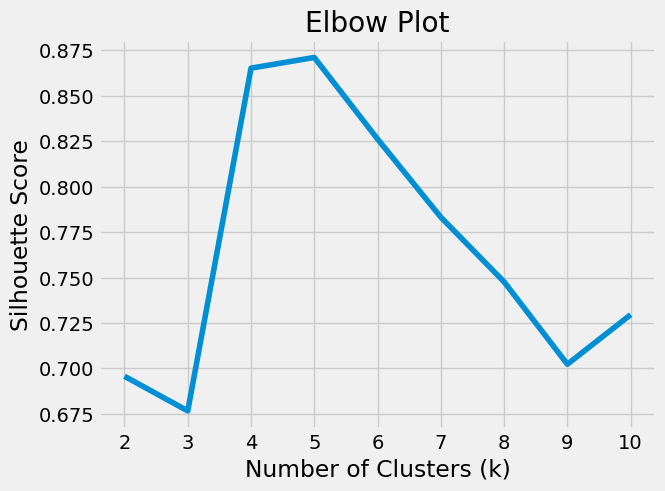

In [111]:
plt.plot(range(2, 11), silhouette_scores)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Elbow Plot')
plt.show();

The point at which silhouette score significantly decreases is at cluster N= 5. Hence choosing 5 CLuster for the algorithm

In [112]:


n_clusters = 5

# Perform k-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(X)

# Add the cluster labels to the original data
rfm['cluster'] = kmeans.labels_


### Model Evaluation

In [113]:

from sklearn.metrics import silhouette_score

labels = kmeans.labels_
silhouette_avg = silhouette_score(X, labels)
print(silhouette_avg)

0.8710993248076542


### Model Result

In [114]:
rfm.head()

,CustomerID,recency,frequency,monetary,recency_score,frequency_score,monetary_score,rfm_score,cluster
1,12347.0,24,182,4310.00,4,5,5,455,3
2,12348.0,97,27,1437.24,2,3,4,234,2
3,12349.0,40,72,1457.55,4,4,4,444,3
4,12350.0,332,16,294.40,1,2,2,122,0
5,12352.0,58,77,1385.74,3,4,4,344,1


#### Analysing the characteristics of the customers in clusters

#### Boxplot

Box plot help us understand the distribution of customers on each clusters according to their purchase characteristics.


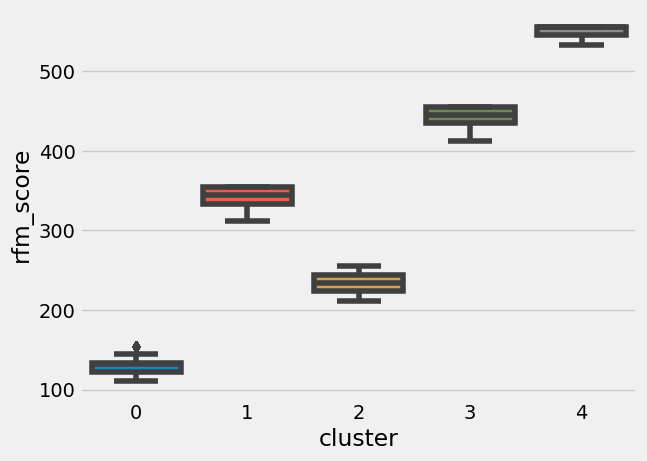

In [115]:
sns.boxplot(x='cluster', y='rfm_score', data=rfm);


#### Histogram on rfm_score

Histogram helps us identify distribution of the overall data.

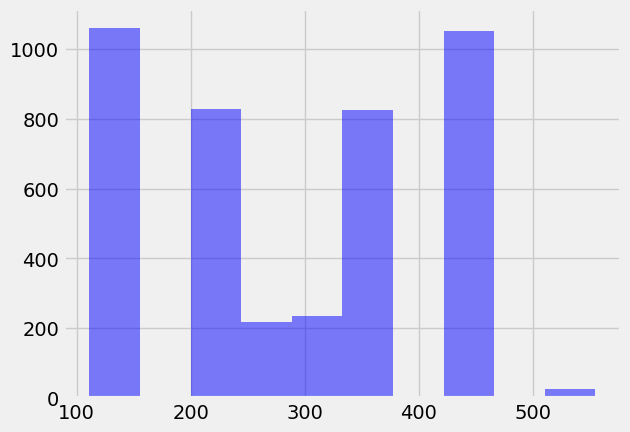

In [116]:
plt.hist(rfm['rfm_score'], color='blue', alpha=0.5);


Since the data is skewed towards right, I use median to identify central tendency of each cluser.


In [117]:
# Calculating median RFM scores for each cluster
cluster_characteristics = rfm.groupby('cluster')['rfm_score'].agg(['median', 'min', 'max']).reset_index()
cluster_characteristics

,cluster,median,min,max
0,0,132.0,111,155
1,1,344.0,312,355
2,2,234.0,212,255
3,3,445.0,412,455
4,4,555.0,533,555


# PHASE 5: Customer Segmentation

### Customer Segmentation based on model result

In [118]:
# function to plot output

def plot_customer_segment(df, segment_column,hue=None):
  fig, ax = plt.subplots(figsize=(10,5))
  fig.facecolor="white"
  fig.edgecolor="white"

  ax.grid(ls="dotted",lw=0.5,color="white",zorder=1);
  if hue:
    bar_ap = sns.countplot(data = df,x = segment_column , hue=hue);
  else:
    bar_ap = sns.countplot(data = df,x = segment_column );
  total = len(rfm['cluster'])
  for patch in ax.patches:
      percentage = '{:.1f}%'.format(100 * patch.get_height()/total)
      x = patch.get_x() + patch.get_width() / 2 - 0.17
      y = patch.get_y() + patch.get_height() * 1.005
      ax.annotate(percentage, (x, y), size = 14)
      
  bar_ap.set_xticklabels(bar_ap.get_xticklabels(), rotation=90);
  plt.title('Number of Customers by Segments', size = 16, color="black");
  plt.ylabel('Count', size = 16,color="black")
  plt.xlabel("segment",fontsize = 16,color="black")
  plt.xticks(size = 10)
  plt.yticks(size = 10)
  plt.show();

#### Targeting losing customers

Recency score measures the time since the customer's last purchase. Customers who have a low Recency score (i.e., they made a purchase recently) are considered more engaged and active, while customers with a high Recency score (i.e., it has been a long time since their last purchase) are considered at risk of churn or disengagement.

In [119]:
# segmenting based on central tendency of the clusters
recency_segments = {
    'Highly Active': (111, 155),
    'Loyal': (212, 255),
    'Promising': (312, 355),
    'Low Value': (412, 455),
    'At Risk': (533, 555)
}

# Function to assign segment based on recency score
def assign_segment(recency_score):
    for segment, (min_score, max_score) in recency_segments.items():
        if min_score <= recency_score <= max_score:
            return segment

# Create a new column 'segment' based on recency score
cluster_characteristics['segment'] = cluster_characteristics['median'].apply(assign_segment)

# creating dictionary 
cluster_segment_dict = dict(zip(cluster_characteristics['cluster'], cluster_characteristics['segment']))

rfm['segmentation_1'] = rfm['cluster'].map(cluster_segment_dict)
rfm

,CustomerID,recency,frequency,monetary,recency_score,frequency_score,monetary_score,rfm_score,cluster,segmentation_1
1,12347.0,24,182,4310.00,4,5,5,455,3,Low Value
2,12348.0,97,27,1437.24,2,3,4,234,2,Loyal
3,12349.0,40,72,1457.55,4,4,4,444,3,Low Value
4,12350.0,332,16,294.40,1,2,2,122,0,Highly Active
5,12352.0,58,77,1385.74,3,4,4,344,1,Promising
...,...,...,...,...,...,...,...,...,...,...
4328,18278.0,95,9,173.90,2,2,2,222,2,Loyal
4329,18280.0,299,10,180.60,1,2,2,122,0,Highly Active
4330,18281.0,202,7,80.82,1,2,2,122,0,Highly Active
4331,18282.0,29,12,178.05,4,2,2,422,3,Low Value


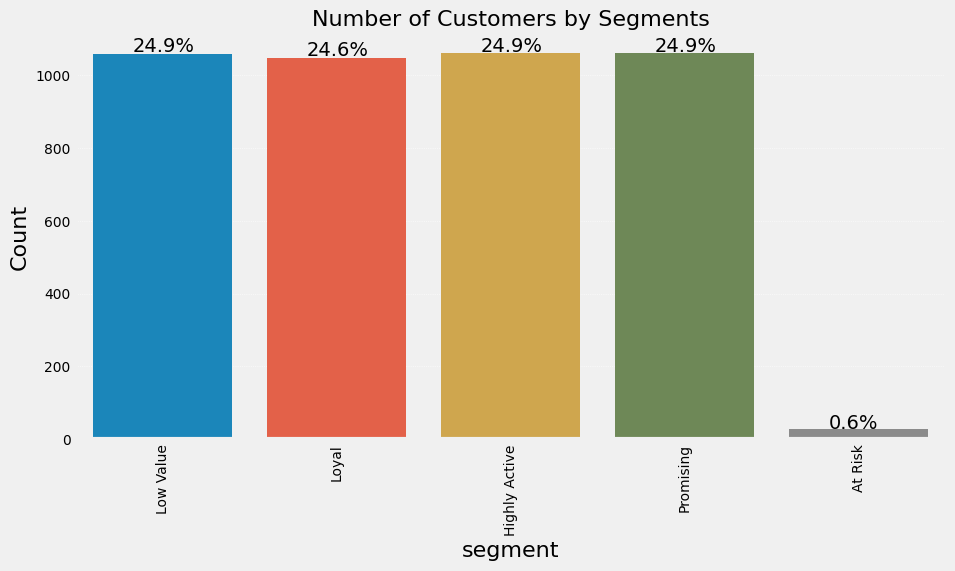

In [120]:
plot_customer_segment(rfm, "segmentation_1")

Implementing strategies such as personalized offers, reactivation campaigns, or targeted communication, can increase the chances of retaining and re-engaging losing customers under "Low Value" and "At Risk" segment.

#### Rewarding customers

Rewarding customers are those who have Repeat purchase behavior.Many businesses have loyalty programs to incentivize repeat purchases. Frequency of transactions is often a core metric in these programs, as it directly measures customer engagement and participation. High-frequency customers can earn more rewards, benefits, or exclusive offers, which can further reinforce their loyalty and encourage them to continue making frequent purchases.

using the frequency score segmenting the clusters to identify customers who needs to be rewarded.

In [121]:
# Creating a dictionary to map the segment based on frequency score
segment_mapping = {4: 'rewarding', 5: 'rewarding', 1: 'not rewarding', 2: 'not rewarding', 3: 'not rewarding'}

# Map the segment based on the frequency score within each cluster
rfm['segmentation_2'] = rfm['frequency_score'].map(segment_mapping)

In [122]:
rfm[['cluster','segmentation_2']].value_counts()

cluster  segmentation_2
0        not rewarding     848
3        rewarding         781
1        rewarding         640
2        not rewarding     597
         rewarding         450
1        not rewarding     420
3        not rewarding     277
0        rewarding         212
4        rewarding          25
         not rewarding       2
dtype: int64

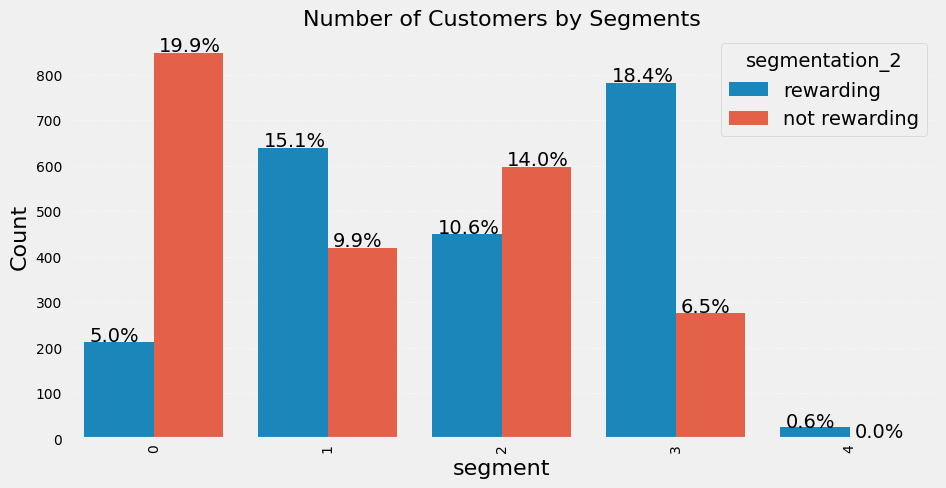

In [66]:
plot_customer_segment(rfm,"cluster" ,"segmentation_2")